<h1> Parameter Tunning 
    
    Look at epochs duration (1 year of data used)

# Importing libraries:

In [25]:
!pip install pandas
!pip install sklearn

import pandas as pd
import numpy as np

# Import data; fill nan values; split data intro train and test

In [26]:
# import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

# for later use
features_num = 15

# 2018 data
data = data.loc[data.index > 2018000000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values
data.fillna(method = 'ffill', inplace = True)

from sklearn.model_selection import train_test_split

# divide data into train and test 
data_train, data_test = train_test_split(
         data, test_size = 0.15, shuffle=False)

# Apply feature scaling:

In [27]:
from sklearn.preprocessing import MinMaxScaler

# data scaling  (including offer (y))
sc_X = MinMaxScaler()
data_train = sc_X.fit_transform(data_train)
data_test = sc_X.transform(data_test)

# Importing the Keras libraries and packages:

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping

mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []
prediction_list = []
time_count = []

# Prepare of data according to LSTM needs,  create regressor & tune:

In [29]:
# parameters
steps = 100
n_hidden = 1
units = 20
batch_size = 100

# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# divide features and labels
X_train = data_train[:, 0:15] 
y_train = data_train[:, -1]
X_test = data_test[:, 0:15] 
y_test = data_test[:, -1] 

# divide data into train and test 
X_train, X_val, y_train, y_val = train_test_split(
         X_train, y_train, test_size = 0.15, shuffle=False)

# put data into correct shape
X_train, y_train = split_data(X_train, y_train, steps)
X_test, y_test = split_data(X_test, y_test, steps)
X_val, y_val = split_data(X_val, y_val, steps)

X_train = cut_data(X_train, batch_size)
y_train = cut_data(y_train, batch_size)
X_test = cut_data(X_test, batch_size)
y_test = cut_data(y_test, batch_size)
X_val = cut_data(X_val, batch_size)
y_val = cut_data(y_val, batch_size)

epochs_range = [50, 75, 100, 125, 150, 200, 400]

for i in epochs_range:
    start_time = time.time()
    
    # design the LSTM
    def regressor_tunning(kernel_initializer = 'he_normal',
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        model.add(LSTM(units = units,                    
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       return_sequences = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
        for layer in list(reversed(range(n_hidden))):
            if layer == 0:
                model.add(LSTM(units = units, 
                               kernel_initializer = kernel_initializer,
                               bias_initializer = bias_initializer))
                model.add(LeakyReLU(alpha = 0.2))
                model.add(Dropout(0.2))
            else:
                model.add(LSTM(units = units, 
                               batch_input_shape = (batch_size, steps, features_num), 
                               stateful = True,
                               return_sequences = True,
                               kernel_initializer = kernel_initializer,
                               bias_initializer = bias_initializer))
                model.add(LeakyReLU(alpha = 0.2))
                model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = 'Adamax')
        return model

    model = regressor_tunning()

    # apply patience callback
    early_stopping = EarlyStopping(monitor='val_mse', patience=10)

    # fitting the LSTM to the training set
    history = model.fit(X_train,
                        y_train, 
                        batch_size = batch_size, 
                        epochs = i,
                        shuffle = False, 
                        validation_data = (X_val, y_val),
                        callbacks = early_stopping)

    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)

    # prices col = 15
    y_pred = (y_pred * sc_X.data_range_[15]) + (sc_X.data_min_[15])
    y_test = (y_test * sc_X.data_range_[15]) + (sc_X.data_min_[15])

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525

    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)

    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================

    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])

    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values


    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)


    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]

    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)

    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)

    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================

    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)

    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 

    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]

    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)

    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)

    elapsed_time = time.time() - start_time

    time_count.append(elapsed_time)

# Make predictions with rmse & mae during training

In [ ]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

In [ ]:
# create plots with rmse & mae during training
rmse = []
val_rmse = []

for i in history.history['mse']:
    rmse.append(i ** 0.5)
    
for i in history.history['val_mse']:
    val_rmse.append(i ** 0.5)
    
plt.figure(figsize=(9,4))
plt.plot(rmse, label = 'train')
plt.plot(val_rmse, label = 'test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('RMSE(£/MWh)')
plt.tight_layout()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('RMSE during training for an initial LSTM architecture')
# plt.savefig('RMSE_1000_epochs_initial_LSTM.png')
plt.show()

plt.figure(figsize=(9,4))
plt.plot(history.history['mae'], label = 'train')
plt.plot(history.history['val_mae'], label = 'test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MAE(£/MWh)')
plt.tight_layout()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('MAE during training for an initial LSTM architecture')
# plt.savefig('MAE_1000_epochs_initial_LSTM.png')
plt.show()

# Save results into a data frame:

In [ ]:
# Save
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor,
                       
                        'time': time_count}, index = epochs_range)

In [ ]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

In [33]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


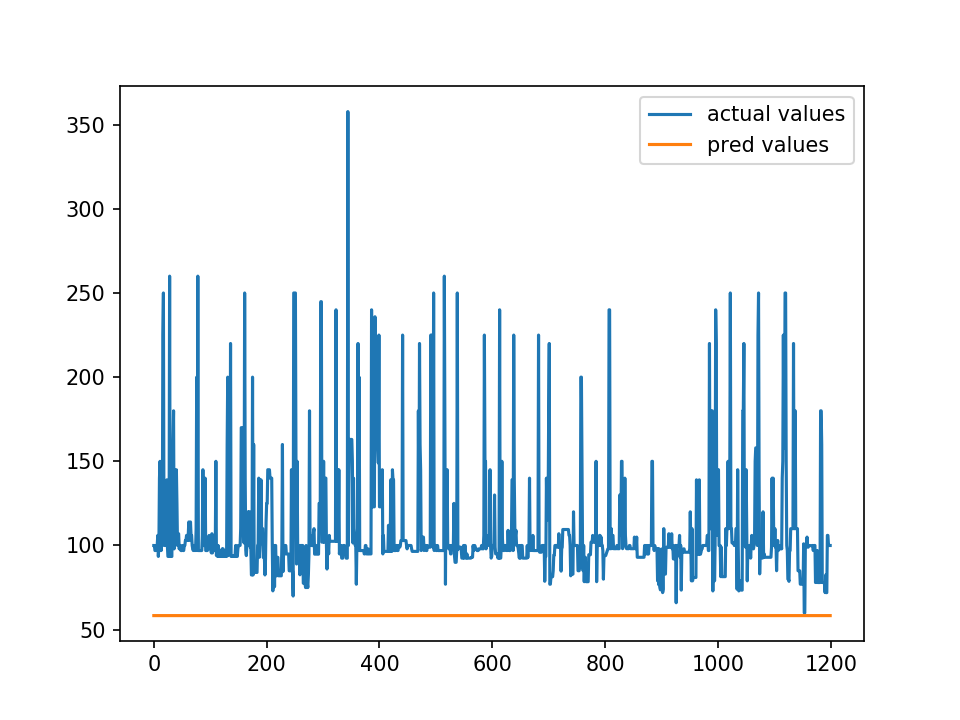

In [35]:
plt.plot(y_test, label = 'actual values')
plt.plot(y_pred, label = 'pred values')
plt.legend()
plt.show()